In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.utils import to_categorical

# Load the MNIST dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Filter the dataset to keep only labels 0-3
train_filter = np.isin(train_labels, [0, 1, 2, 3])
test_filter = np.isin(test_labels, [0, 1, 2, 3])

train_images, train_labels = train_images[train_filter], train_labels[train_filter]
test_images, test_labels = test_images[test_filter], test_labels[test_filter]

# Normalize the images
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

# Convert labels to one-hot encodings
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

# Define the DNN model
model = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(4, activation='linear')  # This is the just-before classifier head
])

# Add classifier head
model.add(Dense(4, activation='softmax'))  # This is the just-after classifier head

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [2]:
# Train the model
model.fit(train_images, train_labels, epochs=5, batch_size=32, verbose=1, validation_data=(test_images, test_labels))

Epoch 1/5
774/774 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9414 - loss: 0.1943 - val_accuracy: 0.9870 - val_loss: 0.0364
Epoch 2/5
774/774 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9869 - loss: 0.0428 - val_accuracy: 0.9928 - val_loss: 0.0241
Epoch 3/5
774/774 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9897 - loss: 0.0296 - val_accuracy: 0.9921 - val_loss: 0.0214
Epoch 4/5
774/774 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9939 - loss: 0.0203 - val_accuracy: 0.9933 - val_loss: 0.0243
Epoch 5/5
774/774 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9937 - loss: 0.0185 - val_accuracy: 0.9937 - val_loss: 0.0185


In [24]:

# Extract features from the just-before and just-after classifier head layers
extractor = Sequential(model.layers[:-1])  # Excludes the final softmax activation layer
features_before_softmax = extractor.predict(test_images)
features_after_softmax = model.predict(test_images)


130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [25]:

# Apply MDS to reduce dimensions
mds = MDS(n_components=2, random_state=42)
mds_coords_before = mds.fit_transform(features_before_softmax)
mds_coords_after = mds.fit_transform(features_after_softmax)


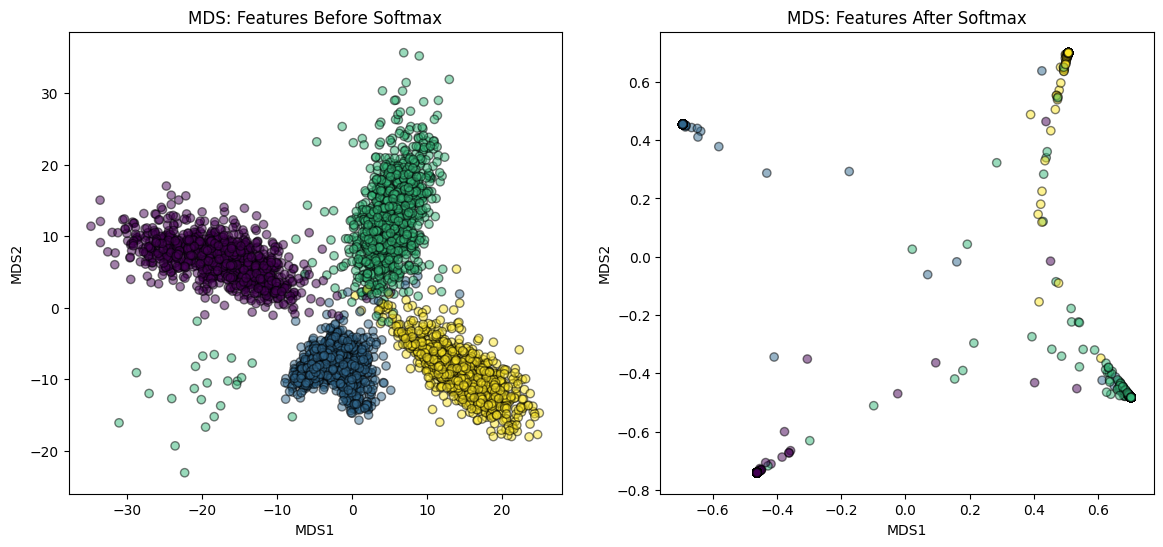

In [26]:

# Get labels for coloring
labels = np.argmax(test_labels, axis=1)

# Plotting the results
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

ax[0].scatter(mds_coords_before[:, 0], mds_coords_before[:, 1], c=labels, cmap='viridis', alpha=0.5, edgecolor='k')
ax[0].set_title('MDS: Features Before Softmax')
ax[0].set_xlabel('MDS1')
ax[0].set_ylabel('MDS2')

ax[1].scatter(mds_coords_after[:, 0], mds_coords_after[:, 1], c=labels, cmap='viridis', alpha=0.5, edgecolor='k')
ax[1].set_title('MDS: Features After Softmax')
ax[1].set_xlabel('MDS1')
ax[1].set_ylabel('MDS2')

plt.show()

Standard MDS on all classes

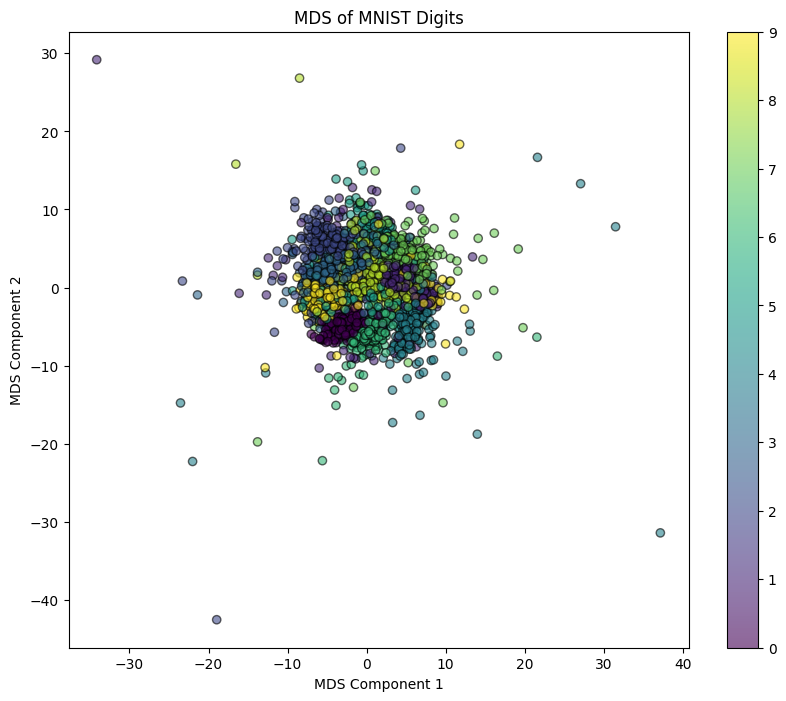

In [23]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.manifold import MDS
from sklearn.preprocessing import StandardScaler

# Load the dataset
digits = load_digits()
data = digits.data
target = digits.target

# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Initialize MDS
mds = MDS(n_components=2, random_state=42)

# Fit and transform the data
mds_transformed = mds.fit_transform(data_scaled)

# Plotting the result
plt.figure(figsize=(10, 8))
scatter = plt.scatter(mds_transformed[:, 0], mds_transformed[:, 1], c=target, cmap='viridis', edgecolor='k', alpha=0.6)
plt.colorbar(scatter)
plt.title('MDS of MNIST Digits')
plt.xlabel('MDS Component 1')
plt.ylabel('MDS Component 2')
plt.show()


### Tried the GPU Optimsied version - but Rapids is not compatible with Colab

In [22]:
# Install RAPIDS
!wget https://raw.githubusercontent.com/rapidsai/rapidsai-csp-utils/branch-22.08/colab/rapids-colab.sh
!chmod +x rapids-colab.sh
!./rapids-colab.sh

import sys, os

# FIX to handle different install paths of libffi which cuDF requires but isn't properly setup in Colab environments
sys.path.append('/usr/local/lib/python3.7/site-packages/libffi.so.7')
os.environ['NUMBAPRO_NVVM'] = '/usr/local/cuda/nvvm/lib64/libnvvm.so'
os.environ['NUMBAPRO_LIBDEVICE'] = '/usr/local/cuda/nvvm/libdevice/'

# This helps handle the path where Colab installs your packages by default
dist_package_index = sys.path.index('/usr/local/lib/python3.6/dist-packages')
sys.path = sys.path[:dist_package_index] + ['/usr/local/lib/python3.7/dist-packages'] + sys.path[dist_package_index:]
sys.path

exec(open('rapidsai-csp-utils/colab/update_modules.py').read(), globals())


--2024-11-26 05:19:35--  https://raw.githubusercontent.com/rapidsai/rapidsai-csp-utils/branch-22.08/colab/rapids-colab.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2024-11-26 05:19:35 ERROR 404: Not Found.

chmod: cannot access 'rapids-colab.sh': No such file or directory
/bin/bash: line 1: ./rapids-colab.sh: No such file or directory


ValueError: '/usr/local/lib/python3.6/dist-packages' is not in list

In [16]:
!pip install cuml

  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for cuml
  Running setup.py clean for cuml
Failed to build cuml
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (cuml)


In [20]:
# Create a new conda environment and install cuml
!conda create -n rapids-0.19 -c rapidsai -c nvidia -c conda-forge cuml=0.19 cudatoolkit=11.0 python=3.7
!conda activate rapids-0.19


/bin/bash: line 1: conda: command not found
/bin/bash: line 1: conda: command not found


In [21]:
import cudf
import cuml
import numpy as np

# Generate or load your dataset
from sklearn.datasets import load_digits
data, _ = load_digits(return_X_y=True)
data = data.astype(np.float32)

# Convert your dataset to a cuDF DataFrame for GPU processing
gdf = cudf.DataFrame(data)

# Initialize and fit MDS using cuML
mds = cuml.MDS(n_components=2)
mds_embedding = mds.fit_transform(gdf)

# Convert the output back to a NumPy array if needed for further processing with CPU-based libraries
mds_embedding_cpu = mds_embedding.to_pandas().values

# Plotting (optional, using Matplotlib)
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.scatter(mds_embedding_cpu[:, 0], mds_embedding_cpu[:, 1], cmap='viridis', alpha=0.5, edgecolor='k')
plt.title('MDS Representation (GPU Optimized)')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()


ModuleNotFoundError: No module named 'cuml'